In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
import datetime as dt

In [2]:
# Загрузка данных
bit = pd.read_csv('CBBTCUSD (1).csv')
brent = pd.read_csv('DCOILBRENTEU (1).csv')
frs = pd.read_csv('FEDFUNDS (1).csv')
sp500 = pd.read_csv('SP500 (1).csv')
dxy = pd.read_csv('DTWEXBGS (1).csv')
xau = pd.read_csv('XAU_USD Historical Data (3).csv', thousands = ',')

In [3]:
#Оставляем только цену
xau = xau.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis = 1)

In [4]:
#Преобразуем дату для золота
xau['Date'] = pd.to_datetime(xau['Date'])
xau['Date'] = xau['Date'].dt.strftime('%Y-%m-%d')

In [5]:
#Переименовываем дату для золота
xau = xau.rename(columns = {'Date':'observation_date'})

In [6]:
# Объединение данных
df = bit.merge(frs, how='inner').merge(sp500, how='inner').merge(dxy, how='inner').merge(brent, how='inner').merge(xau, how = 'inner')

In [7]:
# Переименование столбцов
data = df.rename(columns={
    'observation_date': 'date',
    'CBBTCUSD': 'BTC',
    'FEDFUNDS': 'FFR',
    'SP500': 'SP500',
    'DTWEXBGS': 'DXY',
    'DCOILBRENTEU': 'OIL',
    'Price' : 'XAU'
})

In [8]:
#Меняем формат для золота
data['XAU'] = pd.to_numeric(data['XAU'])

In [9]:
# Преобразование даты
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')
data = data[data['date'] > '2020-07-01']

In [10]:
# Создание логарифмированных переменных
data['ln_BTC'] = np.log(data['BTC'])
data['ln_SP500'] = np.log(data['SP500'])
data['ln_DXY'] = np.log(data['DXY'])
data['ln_OIL'] = np.log(data['OIL'])
data['ln_XAU'] = np.log(data['XAU'])

In [11]:
# Создание первых разностей
data['Delta_ln_BTC'] = data['ln_BTC'].diff()
data['Delta_ln_SP500'] = data['ln_SP500'].diff()
data['Delta_ln_DXY'] = data['ln_DXY'].diff()
data['Delta_ln_OIL'] = data['ln_OIL'].diff()
data['Delta_ln_XAU'] = data['ln_XAU'].diff()
data['Delta_FFR'] = data['FFR'].diff()

In [12]:
# Удаление первой строки с NaN
data = data.dropna()


In [13]:
# Тест Дики-Фуллера для проверки стационарности
print("Тест Дики-Фуллера для Delta_ln_BTC:")
#print(adfuller(data['Delta_ln_BTC'].dropna()))
adf_result = adfuller(data['Delta_ln_BTC'].dropna())
adf_stat, pvalue, usedlag, nobs, crit, icbest = adf_result

print(f"ADF-статистика: {adf_stat:.3f}")
print(f"p-value: {pvalue:.5f}")
print("Критические значения:")
for k, v in crit.items():
    print(f"    {k}: {v:.3f}")
print(f"Выбранное число лагов: {usedlag}, число наблюдений: {nobs}")

# Интерпретация результата
if adf_stat < crit['5%'] and pvalue < 0.05:
    print(" Ряд Delta_ln_BTC СТАЦИОНАРЕН (отвергается гипотеза о единичном корне на 5% уровне значимости).")
else:
    print(" Ряд Delta_ln_BTC НЕСТАЦИОНАРЕН (нет оснований отвергнуть гипотезу о единичном корне на 5% уровне значимости).")

Тест Дики-Фуллера для Delta_ln_BTC:
ADF-статистика: -4.250
p-value: 0.00054
Критические значения:
    1%: -3.548
    5%: -2.913
    10%: -2.594
Выбранное число лагов: 0, число наблюдений: 58
 Ряд Delta_ln_BTC СТАЦИОНАРЕН (отвергается гипотеза о единичном корне на 5% уровне значимости).


In [14]:
# Функция для создания лагов
def create_lags(data, column, lags):
    for i in range(1, lags+1):
        data[f'{column}_lag{i}'] = data[column].shift(i)
    return data

# Создание лагов для зависимой переменной
data = create_lags(data, 'Delta_ln_BTC', 1)

# Создание лагов для независимых переменных
for var in ['Delta_ln_SP500', 'Delta_ln_DXY', 'Delta_ln_OIL', 'Delta_FFR', 'Delta_ln_XAU']:
    data = create_lags(data, var, 1)


In [15]:
# Удаление пропущенных значений
data = data.dropna()

# Добавляем уровневые значения в X
X_levels = data[['ln_SP500', 'ln_DXY', 'ln_OIL', 'ln_XAU', 'FFR']]  # уровни

# Всё, что было раньше — разности и лаги разностей
X_diff_lags = data[['Delta_ln_BTC_lag1', 
                   'Delta_ln_SP500', 'Delta_ln_SP500_lag1',
                   'Delta_ln_DXY', 'Delta_ln_DXY_lag1',
                   'Delta_ln_OIL', 'Delta_ln_OIL_lag1',
                    'Delta_ln_XAU', 'Delta_ln_XAU_lag1',
                   'Delta_FFR', 'Delta_FFR_lag1']]

# Объединяем все факторы
X_full = pd.concat([X_diff_lags, X_levels], axis=1)
X_full = sm.add_constant(X_full)
y = data['Delta_ln_BTC']

# Строим расширенную ARDL модель
model_ardl_levels = sm.OLS(y, X_full).fit()
print("\nARDL с уровнями (ECM форма):")
print(model_ardl_levels.summary())

# Для проверки коинтеграции (bound test) — быстрый способ через arch:

from arch.unitroot.cointegration import engle_granger
y = data['ln_BTC']
X = data[['ln_SP500', 'ln_DXY', 'ln_OIL', 'ln_XAU', 'FFR']]
coint_test = engle_granger(y, X)
print("\nEngle-Granger cointegration test p-value:", coint_test.pvalue)
pval = coint_test.pvalue
if pval < 0.05:
    print("Коинтеграция между ln_BTC и макрофакторами обнаружена (отвергается гипотеза об отсутствии коинтеграции на 5% уровне значимости).")
else:
    print("Коинтеграция между ln_BTC и макрофакторами НЕ обнаружена (нет оснований отвергнуть гипотезу об отсутствии коинтеграции).")
    
# Получаем долгосрочные коэффициенты (long-run multipliers)
phi = model_ardl_levels.params['Delta_ln_BTC_lag1']  # обычно это с минусом
longrun = {}
for var in ['ln_SP500', 'ln_DXY', 'ln_OIL', 'ln_XAU', 'FFR']:
    beta = model_ardl_levels.params[var]
    longrun[var] = -beta / phi if phi != 0 else None
print("\nДолгосрочные коэффициенты (long-run multipliers):")
for k, v in longrun.items():
    print(f"{k}: {v:.4f}")



ARDL с уровнями (ECM форма):
                            OLS Regression Results                            
Dep. Variable:           Delta_ln_BTC   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     3.354
Date:                Thu, 07 Aug 2025   Prob (F-statistic):           0.000898
Time:                        16:30:43   Log-Likelihood:                 50.121
No. Observations:                  58   AIC:                            -66.24
Df Residuals:                      41   BIC:                            -31.21
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cons

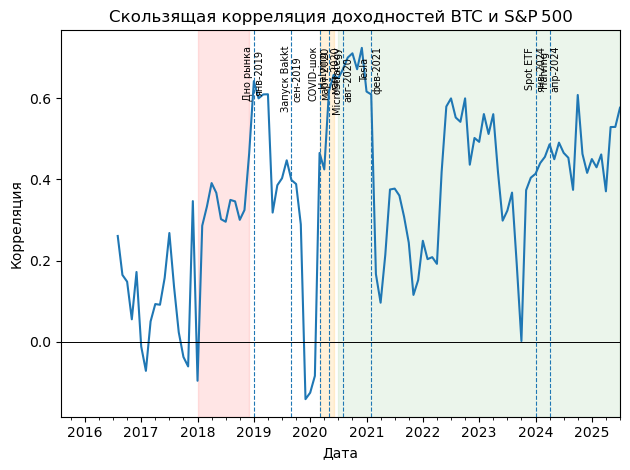

In [16]:
# Пути к файлам
btc_path = 'CBBTCUSD (1).csv'
sp_path  = 'SP500 (1).csv'
# Загрузка данных
btc = pd.read_csv(btc_path, parse_dates=['observation_date']).rename(
    columns={'observation_date': 'Date', 'CBBTCUSD': 'BTC'})
sp  = pd.read_csv(sp_path,  parse_dates=['observation_date']).rename(
    columns={'observation_date': 'Date', 'SP500': 'SP500'})

mt = (btc.set_index('Date')
          .join(sp.set_index('Date'), how='inner')
          .sort_index())

# Список вертикальных событий (label, yyyy-mm-dd)
events = {
    'Дно рынка\nянв‑2019':      '2019-01-01',
    'Запуск Bakkt\nсен‑2019':   '2019-09-01',
    'COVID‑шок\nмарт‑2020':      '2020-03-01',
    'Halving\nмай‑2020':        '2020-05-01',
    'MicroStrategy\nавг‑2020':  '2020-08-01',
    'Tesla\nфев‑2021':          '2021-02-01',
    'Spot ETF\nянв‑2024':       '2024-01-01',
    'Halving\nапр‑2024':        '2024-04-01'
}

# Список интервалов для заливки (label, start, end, color, alpha)
intervals = [
    ('Crypto winter 2018', '2018-01-01', '2018-12-31', 'red',    0.1),
    ('Pandemic turmoil',   '2020-03-01', '2020-06-01', 'orange', 0.15),
    ('Positive corr.',     '2020-07-01', mt.index.max().strftime('%Y-%m-%d'),
                           'green', 0.08)
]
# Скользящая корреляция
returns = mt.pct_change()
rolling_corr = returns['BTC'].rolling(window=12).corr(returns['SP500'])

plt.figure()
rolling_corr.plot()
plt.axhline(0, color='black', linewidth=0.7)

# Заливка интервалов
for label, start, end, color, alpha in intervals:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=alpha)

# Вертикальные линии
for label, date in events.items():
    plt.axvline(pd.to_datetime(date), linestyle='--', linewidth=0.8)
    plt.text(pd.to_datetime(date), plt.ylim()[1]*0.95, label,
             rotation=90, va='top', ha='center', fontsize=7)

plt.title('Скользящая корреляция доходностей BTC и S&P 500')
plt.xlabel('Дата')
plt.ylabel('Корреляция')
plt.tight_layout()
plt.show()


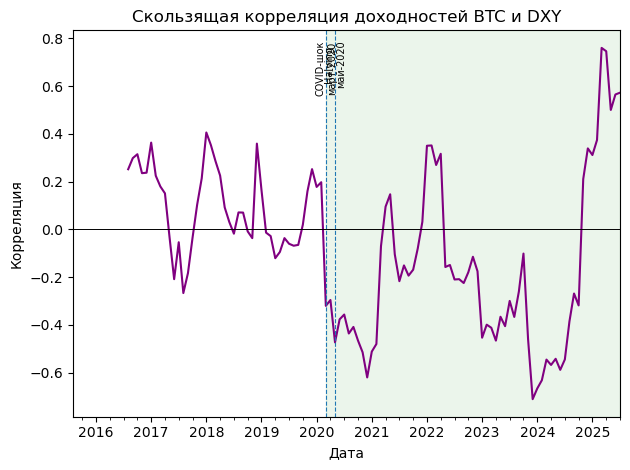

In [17]:

btc_path = 'CBBTCUSD (1).csv'
dxy_path = 'DTWEXBGS (1).csv'

def load_and_standardize(path, target_name):
    data = pd.read_csv(path)
    date_col = [c for c in data.columns if 'date' in c.lower()][0]
    value_col = [c for c in data.columns if c != date_col][0]
    data[date_col] = pd.to_datetime(data[date_col])
    data = data.rename(columns={date_col: 'Date', value_col: target_name})
    return data[['Date', target_name]]

btc = load_and_standardize(btc_path, 'BTC')
dxy = load_and_standardize(dxy_path, 'DXY')

# Теперь объединяем в переменную dt
dt = (btc.set_index('Date')
          .join(dxy.set_index('Date'), how='inner')
          .sort_index())

# Индексация к 100 в янв‑2020
base_date = pd.Timestamp('2020-01-01')
rebased = dt / dt.loc[base_date] * 100

# Доходности и корреляция
returns = dt.pct_change()
rolling_corr = returns['BTC'].rolling(window=12).corr(returns['DXY'])

# Метки событий и интервалы
events = {
    'COVID‑шок\nмарт‑2020': '2020-03-01',
    'Halving\nмай‑2020':    '2020-05-01',
}
intervals = [
    ('Anti‑USD regime', '2020-03-01', dt.index.max().strftime('%Y-%m-%d'),
     'green', 0.08)
]

#Корреляция с долларом
plt.figure()
rolling_corr.plot(color='purple')
plt.axhline(0, color='black', linewidth=0.7)
for label, start, end, color, alpha in intervals:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=alpha)
for label, date in events.items():
    plt.axvline(pd.to_datetime(date), linestyle='--', linewidth=0.8)
    plt.text(pd.to_datetime(date), plt.ylim()[1]*0.95, label,
             rotation=90, va='top', ha='center', fontsize=7)
plt.title('Скользящая корреляция доходностей BTC и DXY')
plt.xlabel('Дата')
plt.ylabel('Корреляция')
plt.tight_layout()
plt.show()

